#                                    CODING CHALLENGE - PART 2

Task is to train an algorithm of your choice to forecast whether it will snow on the following date for each station in this dataset

In [1]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from datetime import datetime, timedelta

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import precision_recall_curve

Dataset 'snow_data.csv' extracted from part-1 is used for part-2. As mentioned in the task, date has been formatted to 
YYYY-MM-DD. 

In [19]:
# Load the dataset, convert to dataframe
data = pd.read_csv('snow_data.csv')

# Convert date columns to YYYY-MM-DD format
data['date'] = pd.to_datetime(data[['year', 'month', 'day']], errors='coerce')
data.drop(['year', 'month', 'day'], axis=1, inplace=True)

# DATA EXPLORATION - IS DATA IMBALANCED?

In [17]:
# Count the occurrences of each class in the 'snow' column
snow_counts = data['snow'].value_counts()

# Calculate the proportion of each class
snow_proportions = snow_counts / len(data)

print("Snow Class Distribution:")
print(snow_counts)
print("\nProportions:")
print(snow_proportions)


#Yes, the classes in the dataset are indeed imbalanced:

#Class '0.0' (No snow) constitutes approximately 89.48% of the dataset.
#Class '1.0' (Snow) constitutes approximately 10.52% of the dataset.

Snow Class Distribution:
snow
False    338037
True      39747
Name: count, dtype: int64

Proportions:
snow
False    0.894789
True     0.105211
Name: count, dtype: float64


In [20]:
#Display the data

data.head()

,station_number,wban_number,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,num_mean_sealevel_pressure_samples,mean_station_pressure,num_mean_station_pressure_samples,...,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado,date
0,725464,99999,61.200001,4,28.000000,4.0,NaN,NaN,NaN,NaN,...,NaN,0.00,NaN,False,False,False,False,False,False,2005-11-01
1,725869,99999,67.599998,4,39.700001,4.0,NaN,NaN,NaN,NaN,...,NaN,0.00,NaN,False,False,False,False,False,False,2005-07-27
2,725940,99999,47.200001,4,41.299999,4.0,1020.500000,4.0,1017.599976,4.0,...,NaN,0.00,NaN,False,False,False,False,False,False,2005-12-12
3,725940,99999,50.400002,4,46.000000,4.0,1024.500000,4.0,1021.700012,4.0,...,NaN,0.14,NaN,False,False,False,False,False,False,2005-03-05
4,725525,99999,85.099998,4,61.700001,4.0,1009.200012,4.0,NaN,NaN,...,NaN,0.00,NaN,False,False,False,False,False,False,2005-09-24


# DATA ANALYSIS

In [22]:
#Data analysis,if any null values, datatypes, etc

data.info()                   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377784 entries, 0 to 377783
Data columns (total 29 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   station_number                      377784 non-null  int64         
 1   wban_number                         377784 non-null  int64         
 2   mean_temp                           377784 non-null  float64       
 3   num_mean_temp_samples               377784 non-null  int64         
 4   mean_dew_point                      377626 non-null  float64       
 5   num_mean_dew_point_samples          377626 non-null  float64       
 6   mean_sealevel_pressure              231937 non-null  float64       
 7   num_mean_sealevel_pressure_samples  231937 non-null  float64       
 8   mean_station_pressure               8715 non-null    float64       
 9   num_mean_station_pressure_samples   8715 non-null    float64       
 10  mean_vis

min_temperature,min_temperature_explicit contains null values, also max_temperature_explicit is of object datatype  

In [23]:
#Check the statistics of dataset

data.describe()

,station_number,wban_number,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,num_mean_sealevel_pressure_samples,mean_station_pressure,num_mean_station_pressure_samples,...,mean_wind_speed,num_mean_wind_speed_samples,max_sustained_wind_speed,max_gust_wind_speed,max_temperature,min_temperature,min_temperature_explicit,total_precipitation,snow_depth,date
count,377784.000000,377784.000000,377784.000000,377784.000000,377626.000000,377626.000000,231937.000000,231937.000000,8715.000000,8715.000000,...,377424.000000,377424.000000,376692.000000,246885.000000,377686.000000,0.0,0.0,332440.000000,6695.000000,377784
mean,725646.806572,67781.067126,48.626222,23.113118,36.668910,23.100862,1016.338527,21.443349,992.858669,18.924269,...,6.944941,23.094859,14.255487,23.519782,38.420422,NaN,NaN,0.066410,6.391830,2007-06-30 18:01:32.853058816
min,725300.000000,3016.000000,-28.299999,4.000000,-30.799999,4.000000,974.500000,4.000000,803.400024,4.000000,...,0.000000,4.000000,1.900000,9.900000,-38.900002,NaN,NaN,0.000000,0.800000,2005-01-01 00:00:00
25%,725434.000000,24027.000000,34.000000,24.000000,23.799999,24.000000,1011.599976,20.000000,983.599976,18.000000,...,4.100000,24.000000,9.900000,18.100000,26.100000,NaN,NaN,0.000000,2.000000,2006-03-31 00:00:00
50%,725527.000000,99999.000000,49.500000,24.000000,35.799999,24.000000,1016.000000,23.000000,993.599976,24.000000,...,6.300000,24.000000,13.000000,22.000000,39.000000,NaN,NaN,0.000000,3.900000,2007-06-29 00:00:00
75%,725846.000000,99999.000000,65.300003,24.000000,51.299999,24.000000,1020.900024,24.000000,1007.400024,24.000000,...,9.000000,24.000000,17.100000,27.000000,53.599998,NaN,NaN,0.010000,7.900000,2008-09-30 00:00:00
max,726284.000000,99999.000000,108.300003,24.000000,81.300003,24.000000,1053.000000,24.000000,1035.699951,24.000000,...,87.400002,24.000000,96.900002,135.000000,127.400002,NaN,NaN,13.360000,61.799999,2009-12-31 00:00:00
std,271.762542,39747.917040,19.443145,3.111862,18.111384,3.124831,7.523333,3.835211,22.337362,8.236492,...,4.240589,3.126000,6.269371,7.389783,18.745335,NaN,NaN,0.237805,6.751067,NaN


From statistics, it can been seen that average of number of samples for various features are almost near to 24 

# DATA PRE-PROCESSING

In [24]:
# Identify numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns
print('numeric cls', numeric_cols)

# Check for NaNs in numeric columns
nan_check = data[numeric_cols].isna().sum()
print("NaNs in each numeric column before handling:\n", nan_check)


# Check for infinite values in numeric columns
inf_check = np.isinf(data[numeric_cols]).sum()
print("Infinite values in each numeric column before handling:\n", inf_check)

# Check for excessively large values
threshold = np.finfo(np.float32).max
large_values_check = (data[numeric_cols] > threshold).sum()
print("Excessively large values in each numeric column:\n", large_values_check)

numeric cls Index(['station_number', 'wban_number', 'mean_temp', 'num_mean_temp_samples',
       'mean_dew_point', 'num_mean_dew_point_samples',
       'mean_sealevel_pressure', 'num_mean_sealevel_pressure_samples',
       'mean_station_pressure', 'num_mean_station_pressure_samples',
       'mean_visibility', 'num_mean_visibility_samples', 'mean_wind_speed',
       'num_mean_wind_speed_samples', 'max_sustained_wind_speed',
       'max_gust_wind_speed', 'max_temperature', 'min_temperature',
       'min_temperature_explicit', 'total_precipitation', 'snow_depth'],
      dtype='object')
NaNs in each numeric column before handling:
 station_number                             0
wban_number                                0
mean_temp                                  0
num_mean_temp_samples                      0
mean_dew_point                           158
num_mean_dew_point_samples               158
mean_sealevel_pressure                145847
num_mean_sealevel_pressure_samples    145847
mean

From the above information as per my knowledge it's understood that mean_sealevel_pressure,mean_station_pressure,
max_gust_wind_speed,min_temperature,min_temperature_explicit,snow_depth have a majority of null values
which doesn't give any relevant information. Also, max_temperature_explicit is a flag with either 
true or false which doesn't provide any detailing. Hence all these columns are meant to be discarded.

Although snow_depth seems to give some relevant information about snow, but from the analysis, it's clear that 
this might cause false positives (when snow is false, snow_depth is having value, and vice versa)

From analysing the data it's clear that the unique id for this data is the combination of station number and date

In [55]:
#sorting them for forecasting

data.sort_values(by=['station_number', 'date'], inplace=True)

In [56]:
#Feature selection for preparing the final dataset.

selected_features = [
     'mean_temp', 'mean_dew_point', 
    'mean_visibility', 'mean_wind_speed',
    'max_temperature','total_precipitation'
]


selected_flag_features = ['snow']

These are the features which I selected for the task as per the analysis

# DATA PREPARATION - feature engineering

In [57]:
# Create a list to store result rows
result_list = []


# Iterate over each station
for station_number, station_data in data.groupby('station_number'):
    
    # Iterate over each date within the station's data
    for i in range(len(station_data)):
        prediction_date = station_data.iloc[i]['date']
        
        # Calculate average temperature of past 7 days
        start_date = prediction_date - pd.DateOffset(days=7)
        end_date = prediction_date - pd.DateOffset(days=1)
        
        # Prepare a dictionary to store the result for the current row
        result_row = {
            'station_number': station_number,
            'date': prediction_date
        }
        
        
        # Filter dates within the past 7 days range and belonging to the same station
        past_week_data = station_data[(station_data['date'] >= start_date) &
                                      (station_data['date'] <= end_date)]
        
        past_day_data = station_data[(station_data['date'] == end_date)]
        actual_date_data = station_data[(station_data['date'] == prediction_date)]
        snow_today = actual_date_data['snow'].sum()
        result_row['snow_today'] = snow_today
        
 
        # Count the number of True flags for each specified column
        for column in selected_flag_features:
            true_count_past_7_days = past_week_data[column].sum()
            true_count_last_day = past_day_data[column].sum()
            result_row[f'{column}_count_past_7_days'] = true_count_past_7_days
            result_row[f'{column}_count_last_day'] = true_count_last_day
            
             
        # Calculate average for each specified column
        for column in selected_features:
            
            avg_temp_past_7_days = past_week_data[column].mean()
            past_day_temp = past_day_data[column].mean()
            result_row[f'{column}_past_7_days'] = avg_temp_past_7_days
            result_row[f'{column}_past_day'] = past_day_temp      
        
        # Append the result to result_list
        result_list.append(result_row)

# Convert the result list to a DataFrame
result_snow_data = pd.DataFrame(result_list)


In [58]:
result_snow_data.to_csv('result_snow_data.csv')

In [59]:
result_snow_data.head()

,station_number,date,snow_today,snow_count_past_7_days,snow_count_last_day,mean_temp_past_7_days,mean_temp_past_day,mean_dew_point_past_7_days,mean_dew_point_past_day,mean_visibility_past_7_days,mean_visibility_past_day,mean_wind_speed_past_7_days,mean_wind_speed_past_day,max_temperature_past_7_days,max_temperature_past_day,total_precipitation_past_7_days,total_precipitation_past_day
0,725300,2005-01-01,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,725300,2005-01-02,1,0,0,32.099998,32.099998,21.200001,21.200001,9.900000,9.9,8.700000,8.7,24.799999,24.799999,0.000000,0.00
2,725300,2005-01-03,1,1,1,37.449999,42.799999,30.650000,40.099998,8.000000,6.1,9.050000,9.4,25.000000,25.200001,0.125000,0.25
3,725300,2005-01-04,1,2,1,36.499999,34.599998,30.966667,31.600000,7.433333,6.3,8.633333,7.8,27.699999,33.099998,0.113333,0.09
4,725300,2005-01-05,1,3,1,35.449999,32.299999,30.575000,29.400000,7.500000,7.7,8.800000,9.3,28.275000,30.000000,0.170000,0.34


Here, first row data for each station contains null values as there is no previous day data. Hence, removing all first rows
of each station from the dataset in the next step

In [60]:

# Initialize an empty list to store modified DataFrames
dfs = []

# Iterate over each station
for station_number, station_data in result_snow_data.groupby('station_number'):
    
    # Drop the first row for each station
    modified_df = station_data.iloc[1:].copy()  # Create a copy without the first row
    dfs.append(modified_df)

# Concatenate all modified DataFrames back together
final_data = pd.concat(dfs)


In [61]:
final_data.head()

,station_number,date,snow_today,snow_count_past_7_days,snow_count_last_day,mean_temp_past_7_days,mean_temp_past_day,mean_dew_point_past_7_days,mean_dew_point_past_day,mean_visibility_past_7_days,mean_visibility_past_day,mean_wind_speed_past_7_days,mean_wind_speed_past_day,max_temperature_past_7_days,max_temperature_past_day,total_precipitation_past_7_days,total_precipitation_past_day
1,725300,2005-01-02,1,0,0,32.099998,32.099998,21.200001,21.200001,9.900000,9.9,8.700000,8.7,24.799999,24.799999,0.000000,0.00
2,725300,2005-01-03,1,1,1,37.449999,42.799999,30.650000,40.099998,8.000000,6.1,9.050000,9.4,25.000000,25.200001,0.125000,0.25
3,725300,2005-01-04,1,2,1,36.499999,34.599998,30.966667,31.600000,7.433333,6.3,8.633333,7.8,27.699999,33.099998,0.113333,0.09
4,725300,2005-01-05,1,3,1,35.449999,32.299999,30.575000,29.400000,7.500000,7.7,8.800000,9.3,28.275000,30.000000,0.170000,0.34
5,725300,2005-01-06,1,4,1,34.299999,29.700001,29.840000,26.900000,6.400000,2.0,10.120000,15.4,27.940000,26.600000,0.168000,0.16


In [63]:
#Checking for null values

NaN_counts = final_data.isnull().sum()
print(NaN_counts)

station_number                         0
date                                   0
snow_today                             0
snow_count_past_7_days                 0
snow_count_last_day                    0
mean_temp_past_7_days                126
mean_temp_past_day                  2687
mean_dew_point_past_7_days           194
mean_dew_point_past_day             2835
mean_visibility_past_7_days         9716
mean_visibility_past_day           12298
mean_wind_speed_past_7_days          300
mean_wind_speed_past_day            3029
max_temperature_past_7_days          127
max_temperature_past_day            2777
total_precipitation_past_7_days     2357
total_precipitation_past_day       47589
dtype: int64


From the above analysis,temperatures can't be set as 0(previous days information is not present) as it's relevant for forecasting. Hence, remove only the NaN rows for these columns. 

In [64]:
#Drop rows with NaN values 

final_data.dropna(subset=['mean_temp_past_7_days', 'mean_temp_past_day', 
                          'max_temperature_past_7_days','max_temperature_past_day'], inplace=True)

In [65]:
#For other rows with NaN values replace it with 0

final_data.fillna(0,inplace=True)

In [66]:
#Save the final data
final_data.to_csv('final_data.csv', index=False)

In [67]:
#Select features and target variables for training the model

X = final_data.drop(columns=['station_number', 'date','snow_today'])
y = final_data['snow_today']

In [68]:
# Split the dataset into train, and validation sets(training set-80%, test set-20%)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# TRAINING WITH DIFFERENT MODELS

# XGB classifier with imbalanced data

In [69]:
# Define XGBoost model
model_xgb = XGBClassifier()

# Train the model on the training data
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# Performance evaluation

In [70]:
# Predictions on the validation set
y_pred_val_xgb = model_xgb.predict(X_val)

# Calculate accuracy on the validation set
accuracy_val_xgb = accuracy_score(y_val, y_pred_val_xgb)
print(f'Validation Accuracy: {accuracy_val_xgb:.2f}')

Validation Accuracy: 0.90


In [71]:

# Classification report for validation set
print("Validation Set Classification Report:")
print(classification_report(y_val, y_pred_val_xgb))

# Confusion matrix for validation set
print("Validation Set Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val_xgb))

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     67037
           1       0.65      0.20      0.31      7921

    accuracy                           0.90     74958
   macro avg       0.78      0.59      0.63     74958
weighted avg       0.89      0.90      0.88     74958

Validation Set Confusion Matrix:
[[66188   849]
 [ 6323  1598]]


ROC-AUC: 0.59


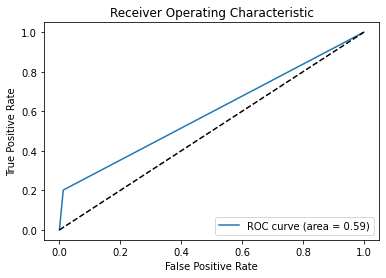

In [72]:
roc_auc = roc_auc_score(y_val, y_pred_val_xgb)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_xgb)

print(f'ROC-AUC: {roc_auc:.2f}')

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

From the above results, it's clear that the model performs very well on class 0(no snow), with high precision, recall, and F1-score. The model performs poorly on class 1 (snow), with low recall indicating that it misses many instances of class 1. The overall accuracy is high(90%), but this is primarily driven by the model's performance on the majority class (class 0). ROC-AUC score of 0.59 indicates that the model's performance is not very effective at differentiating between the two classes.


Techniques like resampling, ensembling, or adjusting class weights might help in improving the performance on the minority class. Below codes are to explore further to manage the imbalance in the data.


In [73]:
#Count for each class before sampling

print(pd.Series(y_train).value_counts())

snow_today
0    268255
1     31577
Name: count, dtype: int64


# Perform Resampling techniques

                                    UNDER SAMPLING

In [74]:
# Apply Random Under-sampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Check class distribution after resampling
print("Class distribution after resampling:")
print(pd.Series(y_train_resampled).value_counts())

Class distribution after resampling:
snow_today
0    31577
1    31577
Name: count, dtype: int64


In [75]:
# Define XGBoost model
model_rus = XGBClassifier()

# Train the model on the training data
model_rus.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [76]:
# Predictions on the validation set
y_pred_val_rus = model_rus.predict(X_val)

# Calculate accuracy on the validation set
accuracy_val_rus = accuracy_score(y_val, y_pred_val_rus)
print(f'Validation Accuracy: {accuracy_val_rus:.2f}')

Validation Accuracy: 0.75


In [77]:

# Classification report for validation set
print("Validation Set Classification Report:")
print(classification_report(y_val, y_pred_val_rus))

# Confusion matrix for validation set
print("Validation Set Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val_rus))

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     67037
           1       0.27      0.77      0.39      7921

    accuracy                           0.75     74958
   macro avg       0.62      0.76      0.62     74958
weighted avg       0.89      0.75      0.80     74958

Validation Set Confusion Matrix:
[[50203 16834]
 [ 1830  6091]]


In [78]:
roc_auc = roc_auc_score(y_val, y_pred_val_rus)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_rus)

print(f'ROC-AUC: {roc_auc:.2f}')



ROC-AUC: 0.76


                                        OVER SAMPLING

In [79]:
# Apply Over-sampling
ros = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)

# Check class distribution after resampling
print("Class distribution after resampling:")
print(pd.Series(y_train_oversampled).value_counts())

Class distribution after resampling:
snow_today
0    268255
1    268255
Name: count, dtype: int64


In [80]:
# Define XGBoost model
model_ros = XGBClassifier()

# Train the model on the training data
model_ros.fit(X_train_oversampled, y_train_oversampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [81]:
# Predictions on the validation set
y_pred_val_ros = model_ros.predict(X_val)

# Calculate accuracy on the validation set
accuracy_val_ros = accuracy_score(y_val, y_pred_val_ros)
print(f'Validation Accuracy: {accuracy_val_ros:.2f}')

Validation Accuracy: 0.77


In [82]:

# Classification report for validation set
print("Validation Set Classification Report:")
print(classification_report(y_val, y_pred_val_ros))

# Confusion matrix for validation set
print("Validation Set Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val_ros))

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.78      0.86     67037
           1       0.28      0.74      0.41      7921

    accuracy                           0.77     74958
   macro avg       0.62      0.76      0.64     74958
weighted avg       0.89      0.77      0.81     74958

Validation Set Confusion Matrix:
[[52129 14908]
 [ 2027  5894]]


In [83]:
roc_auc = roc_auc_score(y_val, y_pred_val_ros)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_ros)

print(f'ROC-AUC: {roc_auc:.2f}')


ROC-AUC: 0.76


Both under-sampling and oversampling techniques gave 75-77% accuracy and a score of 0.76 for ROC-AUC. A score of 0.76 indicates that the model performs reasonably well(compared to previous one) in distinguishing between the two classes. But from the classification report gives a clear picture that the model effectively identifies class 0 instances but struggles more with class 1.

Adjustments may be needed to improve precision for class 1 while maintaining or improving recall for both classes.

# Perform Ensemble technique

In [84]:


# Initialize BalancedRandomForestClassifier
model_brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
# Train the model
model_brf.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


BalancedRandomForestClassifier(random_state=42)

In [85]:
# Predictions on the validation set
y_pred_val_brf = model_brf.predict(X_val)

# Calculate accuracy on the validation set
accuracy_val_brf = accuracy_score(y_val, y_pred_val_brf)
print(f'Validation Accuracy: {accuracy_val_brf:.2f}')

Validation Accuracy: 0.76


In [86]:
# Classification report for validation set
print("Validation Set Classification Report:")
print(classification_report(y_val, y_pred_val_brf))

# Confusion matrix for validation set
print("Validation Set Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val_brf))

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.76      0.85     67037
           1       0.27      0.78      0.41      7921

    accuracy                           0.76     74958
   macro avg       0.62      0.77      0.63     74958
weighted avg       0.89      0.76      0.80     74958

Validation Set Confusion Matrix:
[[50822 16215]
 [ 1771  6150]]


ROC-AUC: 0.77


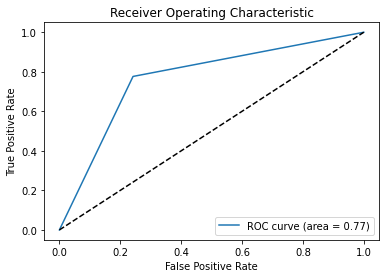

In [87]:
roc_auc = roc_auc_score(y_val, y_pred_val_brf)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_brf)

print(f'ROC-AUC: {roc_auc:.2f}')

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Ensemble technique also gave almost similar results like re-sampling techniques. Applying classification threshold to check if model's performance is improved.

# Classification Threshold

In [88]:
y_pred_proba = model_brf.predict_proba(X_val)[:, 1]


In [91]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

# Find the threshold that gives the best balance between precision and recall
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best Threshold:", best_threshold)

Best Threshold: 0.7


In [92]:
y_pred = (y_pred_proba >= best_threshold).astype(int)

# Evaluate the final predictions

print("Validation Set Classification Report:")
print(classification_report(y_val, y_pred))

print("Validation Set Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.2f}")


Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92     67037
           1       0.41      0.54      0.47      7921

    accuracy                           0.87     74958
   macro avg       0.68      0.72      0.70     74958
weighted avg       0.89      0.87      0.88     74958

Validation Set Confusion Matrix:
[[60779  6258]
 [ 3623  4298]]
ROC-AUC: 0.85


From the above results, it's clear that adding the threshold classification improved the model's performance with a good ROC-AUC score of 0.85 and overall accuracy of 87%. Also,the classification report shows high performance for class 0 (majority class) and moderate performance for class 1 (minority class) with a significant increase in the precision of class 1. 

# Forecasting 

In [96]:
#Calculated date to forecast for 2009-07-06 as I did before

# Prepare data for forecasting
specific_date = datetime(2024, 7, 2) - timedelta(days=15*365)

specific_date_str = specific_date.strftime('%Y-%m-%d')
print(specific_date_str)



2009-07-06


In [127]:
# Prepare data for forecasting
specific_date = datetime.today() - timedelta(days=15*365)

specific_date_str = specific_date.strftime('%Y-%m-%d')
print(specific_date_str)

2009-07-06


In [97]:
#Predictions for selected features 
y_predicted = model_brf.predict(X)


# Add predictions to the temporary final Dataset
final_data_temp = pd.DataFrame(final_data)
final_data_temp['predicted_snowfall'] = y_predicted


In [98]:
# Filter rows where the date column matches the specific date
snow_predicted_date = final_data_temp.loc[final_data_temp['date'] == specific_date_str]

snow_predicted_date = snow_predicted_date[['station_number', 'date', 'predicted_snowfall']]
snow_predicted_date.to_csv('snow_prediction_results.csv', index=False)

In [99]:
snow_predicted_date.head(10)

,station_number,date,predicted_snowfall
1643,725300,2009-07-06,1
3467,725305,2009-07-06,1
5267,725314,2009-07-06,1
7091,725315,2009-07-06,0
8915,725316,2009-07-06,0
10737,725317,2009-07-06,1
12561,725320,2009-07-06,0
14364,725326,2009-07-06,1
16129,725327,2009-07-06,1
17950,725330,2009-07-06,1


snow_prediction_results.csv - Uploaded to github which contains the results from the forecast

Below codes are part of experimenting

# Random Forest classifier with imbalanced data

In [100]:
# Initialize a Random Forest classifier 
model_rf = RandomForestClassifier(random_state=42)

# Train the model 
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [101]:
# Predictions on the validation set
y_pred_val_rf = model_rf.predict(X_val)

# Calculate accuracy on the validation set
accuracy_val_rf = accuracy_score(y_val, y_pred_val_rf)
print(f'Validation Accuracy: {accuracy_val_rf:.2f}')

Validation Accuracy: 0.91


In [102]:
# Classification report for validation set
print("Validation Set Classification Report:")
print(classification_report(y_val, y_pred_val_rf))

# Confusion matrix for validation set
print("Validation Set Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val_rf))

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     67037
           1       0.69      0.19      0.30      7921

    accuracy                           0.91     74958
   macro avg       0.80      0.59      0.63     74958
weighted avg       0.89      0.91      0.88     74958

Validation Set Confusion Matrix:
[[66345   692]
 [ 6391  1530]]


In [103]:
roc_auc = roc_auc_score(y_val, y_pred_val_rf)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_rf)

print(f'ROC-AUC: {roc_auc:.2f}')

ROC-AUC: 0.59
